# Advanced Transforms

Here we cover additional transforms beyond those that we have already seen.

Recall from our first lessons on transforms that performing transforms on data is a key step to finding the most meaningful information in a dataset.

So far, we have seen several different basic transforms:
* Selecting data which meets a certain criteria using masks
* Combining data from multiple DataFrames
* Using pivots to change which of our current columns will be our index and our new columns
* Using melts to perform an inverse pivot where data is returned to "long format" with values and variables

We have also seen a few more advanced transforms:
* Identifying patterns in noise by convolving noisy data against a template pattern
* Identifying cyclic components in a dataset via the Fourier transform
* Projecting high dimensional data to a low dimensional space using principal component analysis (PCA)

This barely scratches the surface of available transforms however! Recall that when we transform data, we work with a goal in mind. We then evaluate candidate transforms based on whether or not they help us make progress towards that goal. By applying sequences of unique transforms to find patterns others cannot see and then validating that those patterns extrapolate out of the domain in which they were uncovered to make meaningful predictions, we can set our minds to solving problems that others have not solved before. The more unique transforms we have in our toolbox the more patterns we will see that others cannot. This will enable us to make scientific discoveries that no one else has made before, extract business value that our competition cannot, and overall move beyond doing what has been do to do what has not been done before.

When planning to solve a problem that others have not solved before, one of the first questions we must ask ourselves is what insights and tools do we possess that others do not, that will uniquely enable us to succeed where they have failed before? Here we will learn a few new tools that may help us later when facing such challenges!

The transforms we will look at here are listed as follows.

* **The Hilbert transform**: The Hilbert transform turns real data into complex data by extracting a natural *complex complement* to pair with a real-valued data sequence. We often measure real data, but find it more mathematically convenient to store and manipulate complex-valued data. The Hilbert transform, among many other applications, can convert our real data to complex data so we can perform manipulations such as extracting the instantaneous frequency and amplitude of a signal.
* **The Short-Time Fourier Transform (STFT)**: The STFT enables us to analyze cyclic data which changes in frequency and has multiple simultaneous frequency components. It presents data on both a time and frequency axis to enable us to see data intuitively the way we hear it, as a progression of tones in time and frequency (analogous to a string of musical notes).
* **The Mellin Transform**: The Mellin transform is mathematically related to the Fourier transform, and will help us perform algebraic operations on random variables in some of these examples. It has many applications beyond this and is worth studying in depth in and of itself!
* **Auto-correlation**: Sometimes when we don't know what signal we are looking for in noisy data, we can correlate the data against itself to find one! This is a simplified version of a technique known as Wigner-Ville Distribution (WVD) analysis. We will look at the simplified technique here and leave the full application of WVD to future lectures for those interested.

We will also see a few nonlinear operations interspersed throughout, including:
* **Logarithmic scaling**: Logarithmic scaling makes patterns that span large ranges of numbers more obvious by making our axes increase relative to a ratio (multiplicative) rather than incrementally (additive). The most common use of logarithmic scaling is to represent signals in decibels.
* **Clipping and Threshold Techniques**: These techniques will remove data above or below a certain threshold, make the data that meets a threshold criteria equal to a given value, or otherwise process data differently if it meets a threshold criteria.

## Matplotlib Techniques

Throughout this notebook, in contract with some previous notebooks where we used a deep stack of tools to create layered visualizations, we will use MatPlotLib with some careful parameter choices to create a professional academic journal appearance to our plots. It is important to know how to visualize data in both styles, for example to create layered visualizations for a map application vs. to create clean and tightly controlled visualizations for an academic journal. We will do this by modifying Matplotlib's *runtime configuration parameters*, or `rcParams`. This will change Matplotlib's runtime configuration from the default settings in its runtime configuration file.

You can see where the default configuration is stored as follows.

```python
import matplotlib
matplotlib.matplotlib_fname()
```

You can learn more about `rcParams` [here](https://matplotlib.org/stable/users/explain/customizing.html).

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["text.usetex"] = True

## Sample Data: Staircase Signal

Here we generate some sample data which will motivate the transforms we will study here. This data will consist of a few tones (say musical notes) which step up in frequency over time. Each tone in this "staircase" increases and then decreases in amplitude as it plays. If this were an audio signal, it might remind us of a violin playing up a musical scale, with each note making a crescendo and decrescendo as it plays. 

We use Matplotlib to make a clean academic style plot of our data. We can use LaTeX in the plot by using raw strings (strings prefaced with `r`) and wrapping our LaTeX notation in `$` delimiters. For those unfamiliar with LaTeX, a great introduction can be found [here](https://www.overleaf.com/learn/latex/Free_online_introduction_to_LaTeX_(part_1)).

Note that for LaTex to render properly, you might need to install a LaTeX distribution if you do not already have one. Any popular LaTeX distribution should work, but [TeX Live](https://www.tug.org/texlive/) is recommended for this class. You can find instructions for installation for your environment on the TeX Live webpage.

[100. 250. 400.]


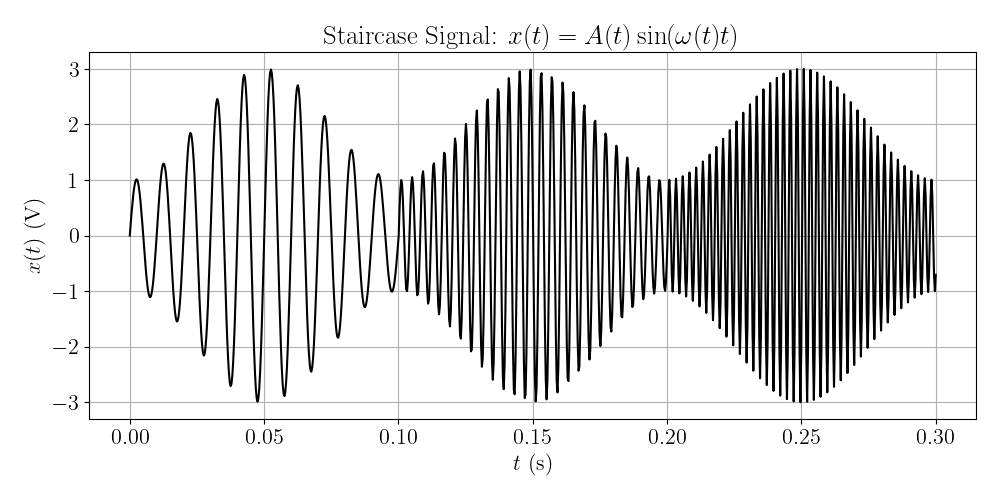

In [2]:
# Define several frequencies for the staircase
start_freq_hz = 100
end_freq_hz = 400
num_frequencies = 3

frequencies_hz = np.linspace(start_freq_hz, end_freq_hz, num_frequencies)
highest_frequency_hz = np.max(frequencies_hz)

# Sample above Nyquist for smooth plots
sampling_rate_hz = 8 * highest_frequency_hz

print(frequencies_hz)


def generate_staircase_signal(frequencies_hz, sampling_rate_hz):
    """Generate a signal with discrete tones that swell in amplitude"""
    num_frequencies = len(frequencies_hz)
    duration_s = 0.1

    total_duration_s = duration_s * num_frequencies

    time_s = np.linspace(
        0, duration_s, int(sampling_rate_hz * duration_s), endpoint=False
    )
    total_time_s = np.linspace(
        0, total_duration_s, int(sampling_rate_hz * total_duration_s)
    )

    # Generate sine waves
    components = []
    for frequency_hz in frequencies_hz:
        component = np.sin(2 * np.pi * frequency_hz * time_s)
        components.append(component)
    signal_v = np.concatenate(components)

    envelope = 2 + np.sin(
        2 * np.pi * (1 / duration_s) * total_time_s - np.pi / 2
    )

    signal_v = envelope * signal_v

    return total_time_s, signal_v


total_time_s, signal_v = generate_staircase_signal(
    frequencies_hz, sampling_rate_hz
)


def plot_signal_time_domain(total_time_s, signal_v):
    """Plot a signal in the time domain."""
    plt.figure(figsize=(10, 5))
    plt.plot(total_time_s, signal_v, color="k")
    plt.title(r"Staircase Signal: $x(t) = A(t)\sin(\omega(t) t)$")
    plt.xlabel(r"$t\ \mathrm{(s)}$")
    plt.ylabel(r"$x(t)\ \mathrm{(V)}$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_signal_time_domain(total_time_s, signal_v)

## Observations

We can note a few immediate observations. First, note that the data has interesting phenomenon in time and frequency. The frequency of the tone changes stepwise over time. This is different than time series data we have seen before which only had frequency components which persisted for the entire duration we were interested in analyzing.

We can represent our signal mathematically as follows.

$$
\begin{align*}
x(t) &= A(t)\sin(\omega(t)t) \\
\omega(t) &= \begin{cases}
    \omega_1 & \forall\ t \in W_1 \\
    \omega_2 & \forall\ t \in W_2 \\
    & \vdots \\
    \omega_N & \forall\ t \in W_N
\end{cases}
\end{align*}
$$

Here $W_n = [a_n, b_n)$ is a window in time. Each frequency $\omega_n$ is only active within its corresponding window $W_n$. Just as frequency varies as a function of time, $\omega(t)$, amplitude, $A(t)$ does as well. Amplitude is given as a function of time as follows.

$$
A(t) = 2 + \sin\left(\frac{2\pi t}{T} - \frac{\pi}{2}\right)
$$

Here $T$ is the duration of each step, such that $b_n - a_n = T$.

Besides the fact that amplitude and frequency both vary with respect to time, which is new to us, we can also note that the visualization of the signal in the time domain is not intuitive. Most viewers would not immediately make the connection to the signals mathematical representation, and only viewers well trained in both math and music would recognize what the signal might sound like.

## Attempting Fourier Analysis

If we attempt Fourier analysis here without applying any other techniques, we will not get much more insights than viewing the data in the time domain gave us.

Recall the definition of the Fourier transform.

$$
\mathcal{F}[f(t)] (\xi) = \int_{-\infty}^{\infty} f(t) e^{-i 2 \pi \xi t} dt.
$$

Also recall that the Fourier transform can be thought of as considering a bank of cyclical signals, and then testing a signal under examination for the presence of each of them. Although the bounds of the integral range from $-\infty$ to $+\infty$, in practice, the signals we analyze with the Fourier transform are finite in time, so the bounds of the integral can be thought of as defaulting to the bounds of the signal, unless we apply some other window to make the signal shorter. We will indeed do that later, but for now, remember that the Fourier transform is integrating our entire signal and testing it for the presence of a bank of candidate sinusoids.

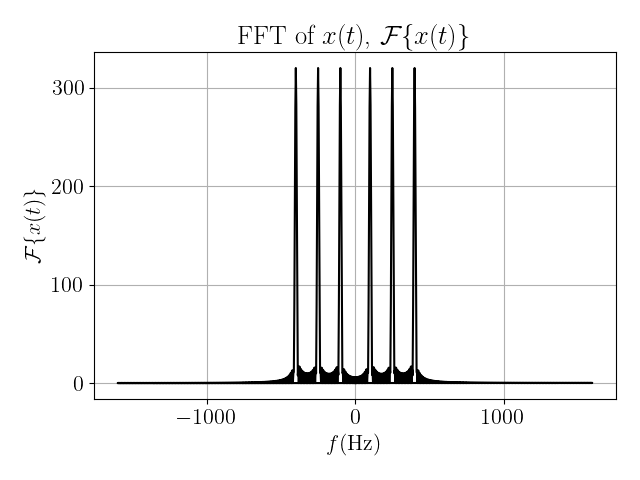

In [3]:
highest_frequency_hz = end_freq_hz


def compute_complex_fourier_transform(signal_v, sampling_rate_hz):
    """Compute the Fourier transform of a given signal."""
    # Compute the FFT
    fft_result = np.fft.fft(signal_v)

    # Compute the frequencies corresponding to the FFT result
    fft_frequencies_hz = np.fft.fftfreq(len(fft_result), 1 / sampling_rate_hz)
    return (fft_frequencies_hz, fft_result)


fft_frequencies_hz, fft_result = compute_complex_fourier_transform(
    signal_v, sampling_rate_hz
)


def plot_complex_fft(fft_frequencies_hz, fft_result):
    """Plots a complex FFT including negative and positive frequencies"""
    plt.figure()
    plt.plot(fft_frequencies_hz, np.abs(fft_result), color="k")
    plt.title(r"FFT of $x(t)$, $\mathcal{F}\{x(t)\}$")
    plt.xlabel(r"$f \mathrm{(Hz)}$")
    plt.ylabel(r"$\mathcal{F}\{x(t)\}$")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_complex_fft(fft_frequencies_hz, fft_result)

First, we notice that we have twice as many tones as we expected. Second, we notice that there is a mirror image effect about $0 \mathrm{Hz}$.

Why are there negative frequencies? And what does it mean to have a frequency of zero? If there is a symmetry, why do we need to show the negative frequencies at all?

In this case, we are seeing negative frequencies incorrectly because we plotted a complex Fourier transform on purely real data. The concept of negative frequency does have an important meaning as we will see later, but in these case it is simply redundant to show the data this way.

We can fix this by letting `numpy` know that we are working with real data by using `rfft`.

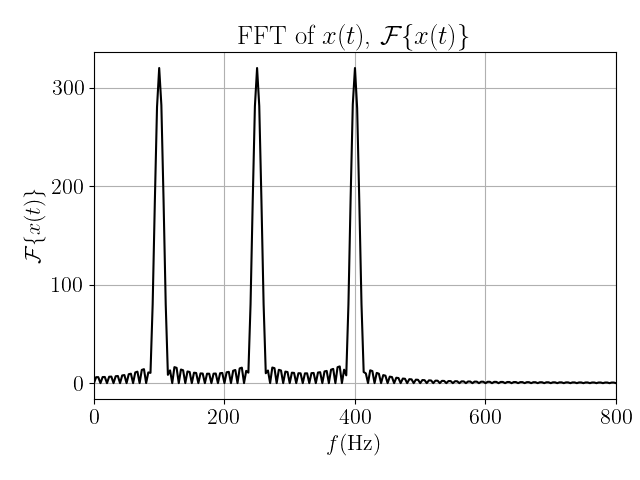

In [4]:
def compute_real_fourier_transform(signal_v, sampling_rate_hz):
    """Compute the Fourier transform of a given signal."""
    # Compute the FFT
    rfft_result = np.fft.rfft(signal_v)

    # Compute the frequencies corresponding to the FFT result
    rfft_frequencies_hz = np.fft.rfftfreq(
        len(total_time_s), 1 / sampling_rate_hz
    )
    return (rfft_frequencies_hz, rfft_result)


rfft_frequencies_hz, rfft_result = compute_real_fourier_transform(
    signal_v, sampling_rate_hz
)


# Plot the FFT result
def plot_real_fft(rfft_frequencies_hz, rfft_result, highest_frequency_hz):
    plt.figure()
    plt.plot(rfft_frequencies_hz, np.abs(rfft_result), color="k")
    plt.title(r"FFT of $x(t)$, $\mathcal{F}\{x(t)\}$")
    plt.xlabel(r"$f \mathrm{(Hz)}$")
    plt.ylabel(r"$\mathcal{F}\{x(t)\}$")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim([0, highest_frequency_hz])
    plt.show()


plot_real_fft(rfft_frequencies_hz, rfft_result, highest_frequency_hz=800)

This looks more intuitive. We can clearly see that we have three tones in our data, and our plot does not spend ink conveying any redundant information. However, some problems still remain with this visualization.

Most critically, we cannot see when each tone begins and ends. We also cannot see the crescendo pattern that seemed to be a key feature of this data. It turns out that we can do better by applying the right transforms.

The first transform we will look at to help us in this situation is the Hilbert transform.

## The Hilbert Transform

### Definition

The Hilbert transform of a function $x(t)$ is defined as

$$
\mathcal{H}\{x(t)\} = \frac{1}{\pi} \int_{-\infty}^{\infty} \frac{x(\tau)}{t - \tau} \, d\tau.
$$

The Hilbert transform can be computed from the Fourier transform by

$$
\mathcal{H}\{x(t)\} = \mathcal{F}^{-1}\{ -i\ \mathrm{sgn}(\omega) \mathcal{F}\{x(t)\}(\omega) \}.
$$

This formula provides insight into what the Hilbert transform is doing when we apply it to a real signal. The Hilbert transform is taking the frequency components of our real data, removing the redundant negative frequency components, then shifting each remaining component by exactly 90 degrees (multiplying by $i$) before returning to the time domain.

One we return to the time domain, we have what is sometimes called a *complex complement* of our original signal. It is easy to see how this works by looking at a few transform pairs.

| $x(t)$ | $\mathcal{H}\{x(t)\}$ |
|--------|-----------------------|
| $\sin(\omega t + \varphi)$    |  $- \cos(\omega t + \varphi),\ \omega > 0$   |
| $\cos(\omega t + \varphi)$    |  $\sin(\omega t + \varphi),\ \omega > 0$   |
| $e^{i \omega t}$ | $e^{i \left(\omega t - \frac{\pi}{2}\right)}$ |

It is clear that given a sinusoid, the Hilbert transform generates another sinusoid that is delayed by exactly 90 degrees.

This reminds us of the components of Euler's formula, where we represent a complex sinusoid as a sum of a real sinusoid and an imaginary sinusoid delayed 90 degrees.

$$
e^{i\omega t} = \cos(\omega t) + i \sin(\omega t)
$$

In Euler's formula, we see a signal, $\cos(\omega t)$, and a signal which complements it, $\sin(\omega t)$. We can gain some intuition into the Hilbert transform by imagining it as a box which accepts as input a given signal and produces the signal which would complement it in Euler's formula as applied to each frequency component in the signal.

Since the Hilbert transform is linear, we can think of it as decomposing its input signal into a list of sinusoids, delaying each by 90 degrees (to generate the complement in Euler's formula) and then summing up the list of delayed sinusoids before returning to the real domain with a complement to the entire original signal.


### Application: Analytic Signals

One of the most important uses of the Hilbert Transform is in generating analytic signals from real signals. An analytic signal is defined as

$$
z(t) = x(t) + i y(t)
$$

where

$$
y(t) = \mathcal{H}\{x(t)\}.
$$

Among many other useful properties, analytic signals:

1. Can be easily frequency shifted by taking advantage of Euler's formula;
2. Can reveal the instantaneous amplitude and instantaneous frequency of our signals.

#### Frequency Shift

Consider an analytic signal $z(t)$ with frequency components $\omega_1 \dots \omega_N$

$$
\begin{align*}
z(t) &= e^{i\omega_1 t} + \dots + e^{i\omega_N t}, \\
     &= \sum_n e^{i\omega_n}.
\end{align*}
$$

Then consider applying Euler's formula to expand each component in the summation, i.e.,

$$
\begin{align*}
z(t) &= y, \\
     &= \cos(\omega_1 t) + \dots + \cos(\omega_N t) + i \left( \sin(\omega_1 t) + \sin(\omega_N t) \right), \\
     &= \sum_n \cos(\omega_n t) + i \sum_n \sin(\omega_n t).
\end{align*}
$$

Here we can clearly see the parts of the analytic signal and where the Hilbert transform fits in.

$$
\underbrace{z(t)}_{\text{analytic signal}} = \underbrace{\sum_n \cos(\omega_n t)}_{x(t)} + i \underbrace{\sum_n \sin(\omega_n t)}_{y(t)=\mathcal{H}\{x(t)\}}.
$$

From this representation, we can see how easily we can shift the frequency of an analytic signal by multiplying it by a complex exponential.

$$
\begin{align*}
z_s(t) &= e^{i\omega_s t} z(t), \\
       &= e^{i\omega_s t} \left( e^{i\omega_1 t} + \dots + e^{i\omega_N t} \right), \\
       &= e^{i (\omega_1 + \omega_s) t} + \dots + e^{i (\omega_N + \omega_s) t}.
\end{align*}
$$

#### Instantaneous Amplitude and Frequency Extraction

The amplitude and frequency of our example signal vary with respect to time. Amplitude and frequency variations are often important attributes of time series data, which change often in real world data rather than remaining static as is common in more trivial examples.

The analytic representation of a signal makes it convenient to extract (and ultimately visualize) these attributes.

Writing the analytic signal in polar form,

$$
\begin{align*}
z(t) = \underbrace{A(t)}_{\text{amplitude}} \exp(i\ \underbrace{\psi(t)}_{\ \text{phase}\ }),
\end{align*}
$$

the amplitude of the signal as at a given time is revealed by computing the magnitude of the complex number at the time of interest.

$$
\begin{align*}
A(t) &= |z(t)|, \\
     &= \sqrt{x^2(t) + y^2(t)}. \\
\end{align*}
$$

The instantaneous phase $\psi(t) = \omega(t) t + \varphi$ is given by the angle of the analytic signal,

$$
\begin{align*}
\psi(t) &= \mathrm{arg}(z(t)), \\
        &= \mathrm{atan2}(y(t), x(t)).
\end{align*}
$$

By differentiating the instantaneous phase we can reveal the instantaneous frequency

$$
\begin{align*}
\omega(t) &= \frac{d}{dt} \psi(t), \\
          &= \frac{d}{dt} \left( \omega(t) t + \varphi \right).
\end{align*}
$$

Below, we see the Hilbert transform in action and visualize the result!

Here we use the `scipy.signal` package to compute the Hilbert transform of our example signal. The `signal.hilbert()` function returns the full analytic signal, $z(t) = x(t) + i y(t)$. Strictly speaking, if we want the Hilbert transform we need to use the following code.

```python
from scipy import signal
hilbert_transform = np.imag(signal.hilbert(signal_v))
```

Once we perform the Hilbert transform, we extract the amplitude envelope by extracting the magnitude of the analytic signal. Then we extract the instantaneous phase $\psi(t)$ using `np.angle` to obtain the argument of the complex function.

Once we extract the instantaneous phase, we differentiate it to obtain the instantaneous frequency. We use `np.diff` to approximate the derivative.

**Warning: while it is acceptable to use a discrete derivative in this example to illustrate the properties of the Hilbert transform, discrete derivatives are prone to amplify noise and should never be used in practical situations where systems must be noise tolerant.**

If a discrete derivative produces good results in offline analysis, then this is acceptable, but even if a discrete derivative produces good results in offline analysis, it should not be used in a production system where critical functions depend on its output because of its tendency to amplify noise.

There are methods to handle this, namely methods where we fit expected forms for the instantaneous phase and then differentiate those forms symbolically, but implementing those details is outside the scope of this introduction to the Hilbert transform.

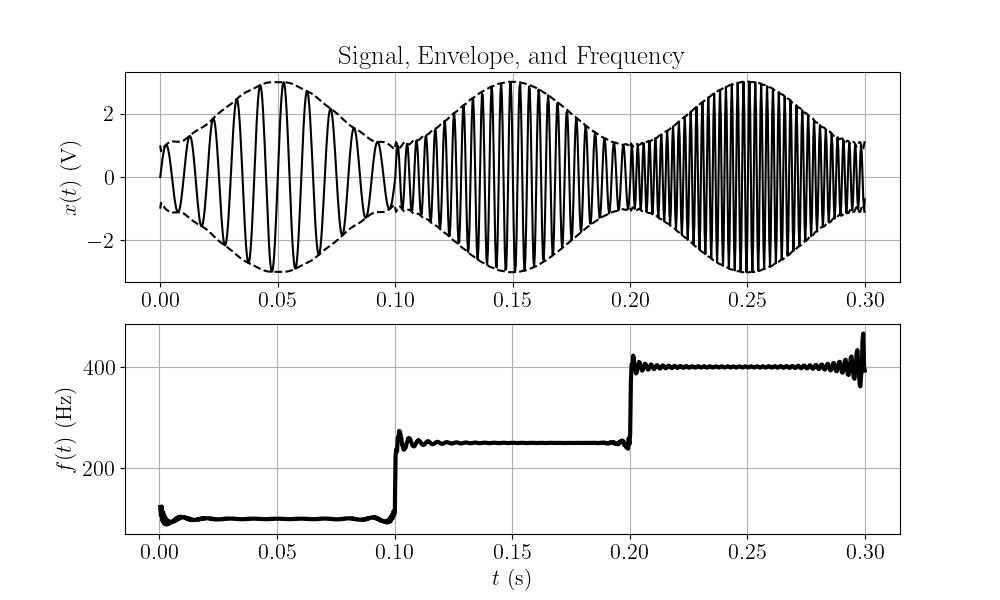

In [5]:
from scipy import signal


def compute_instantaneous_frequency_and_amplitude(
    signal_v, highest_frequency_hz
):
    """Computes the instantaneous frequency and amplitude of a signal."""
    # Sample above Nyquist for smooth plots
    sampling_rate_hz = 8 * highest_frequency_hz
    analytic_signal = signal.hilbert(signal_v)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency_hz = (
        np.diff(instantaneous_phase) / (2.0 * np.pi) * sampling_rate_hz
    )
    return (amplitude_envelope, instantaneous_frequency_hz)


amplitude_envelope, instantaneous_frequency_hz = (
    compute_instantaneous_frequency_and_amplitude(
        signal_v, highest_frequency_hz
    )
)


def plot_signal_with_instantaneous_amplitude_and_frequency(
    signal_v, amplitude_envelope, instantaneous_frequency_hz
):
    _, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 6))
    ax0.plot(total_time_s, signal_v, label="signal", color="k")
    ax0.plot(
        total_time_s,
        np.mean(signal_v) + amplitude_envelope,
        label="envelope",
        color="k",
        linestyle="--",
    )
    ax0.plot(
        total_time_s,
        np.mean(signal_v) - amplitude_envelope,
        label="envelope",
        color="k",
        linestyle="--",
    )
    ax0.grid(True)
    ax0.set_ylabel(r"$x(t)\ \mathrm{(V)}$")
    ax1.plot(
        total_time_s[1:], instantaneous_frequency_hz, color="k", linewidth=3
    )
    ax1.set_xlabel(r"$t\ \mathrm{(s)}$")
    ax1.grid()
    ax1.set_ylabel(r"$f(t)\ \mathrm{(Hz)}$")
    ax0.set_title(r"Signal, Envelope, and Frequency")


plot_signal_with_instantaneous_amplitude_and_frequency(
    signal_v, amplitude_envelope, instantaneous_frequency_hz
)

Now this looks like a useful visualization of our data! We can clearly see the amplitude envelope, and clearly see the step ups in frequency.

## Short Time Fourier Transform

Now we can see how the Hilbert transform can be helpful for visualization when we have a signal with time varying amplitude and frequency components.

But what happens when we have a signal with multiple overlapping time and frequency components?

This situation can cause unexpected results and poor visualization when a Hilbert transform alone is used.

Let's look at a situation where we have two overlapping staircase signals.

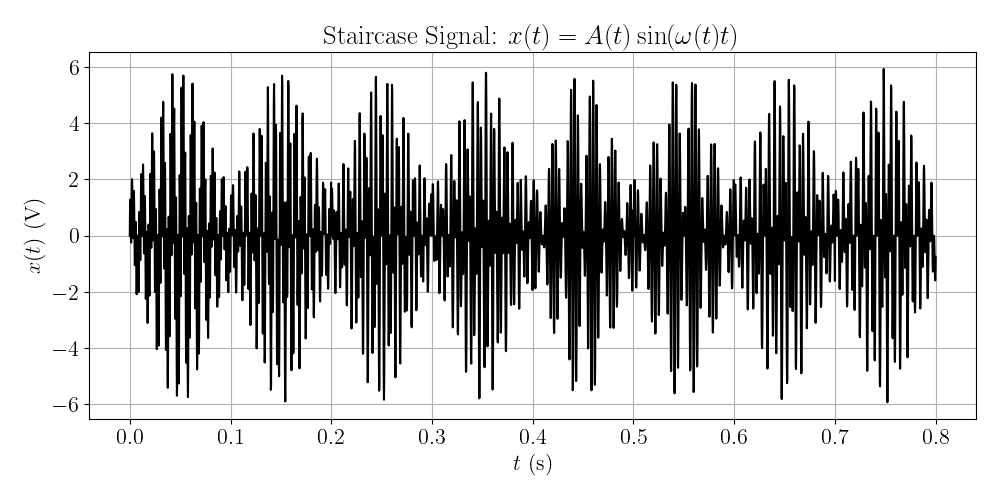

In [6]:
# Ascending Staircase
start_freq_hz = 100
end_freq_hz = 400
num_frequencies = 8

frequencies_ascending_hz = np.linspace(
    start_freq_hz, end_freq_hz, num_frequencies
)

# Descending Staircase
start_freq_hz = 550
end_freq_hz = 150
num_frequencies = 8

frequencies_descending_hz = np.linspace(
    start_freq_hz, end_freq_hz, num_frequencies
)

sampling_rate_hz = 8 * np.max(
    np.concatenate((frequencies_ascending_hz, frequencies_descending_hz))
)

_, ascending_signal_v = generate_staircase_signal(
    frequencies_ascending_hz, sampling_rate_hz
)
total_time_s, descending_signal_v = generate_staircase_signal(
    frequencies_descending_hz, sampling_rate_hz
)

combined_signal_v = ascending_signal_v + descending_signal_v

plot_signal_time_domain(total_time_s, combined_signal_v)

If the time domain plot of our last signal was difficult to decipher without the help of transforms, this time domain plot is near impossible! It is difficult to gain any insights into this signal. Let's try a real domain Fourier transform.

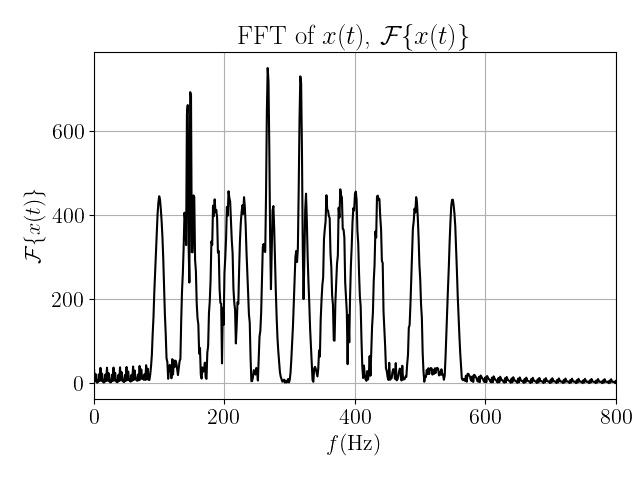

In [7]:
rfft_frequencies_combined_hz, rfft_combined_result = (
    compute_real_fourier_transform(combined_signal_v, sampling_rate_hz)
)

plot_real_fft(
    rfft_frequencies_combined_hz,
    rfft_combined_result,
    highest_frequency_hz=800,
)

That is just as bad as the time domain plot! What about the Hilbert transform?

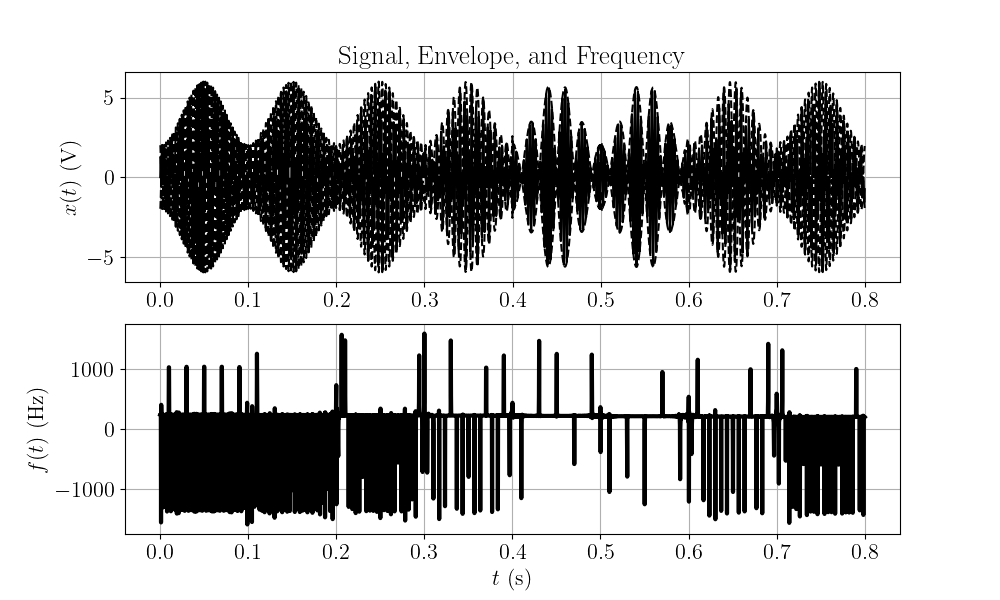

In [8]:
combined_amplitude_envelope, combined_instantaneous_frequency_hz = (
    compute_instantaneous_frequency_and_amplitude(
        combined_signal_v, highest_frequency_hz
    )
)
plot_signal_with_instantaneous_amplitude_and_frequency(
    combined_signal_v,
    combined_amplitude_envelope,
    combined_instantaneous_frequency_hz,
)

This is still not very insightful! What could be going on here?

The difference between this signal and our previous signals is that this signal consists of multiple simultaneous and time varying tones. This is a signal that is rich with interesting details and complexities and is more representative of the type of signals we might find in the wild.

So how can we visualize a signal like this? The trick is to consider what is going on in both short time scales and short segments in frequency. What if we had a way to take the FFT over just a short time, so we could see only the signal components active during that time?

It turns out the Short Time Fourier Transform (STFT) does exactly that. The short time Fourier transform applies a window to our data before computing the Fourier transform, so that the Fourier transform only returns information to us about the frequency components active in that window.

$$
\begin{align}
X(\tau, \omega) &= \mathrm{\mathbf{STFT}\{x(t)\}}(\tau, \omega) \\
                &= \int_{-\infty}^{\infty} x(t)w(t-\tau)e^{-i \omega t}\, dt
\end{align}
$$


When the window is a hard cut off, this effectively changes the bounds of the Fourier integral.

An example with a hard window illustrates this

$$

\begin{align}
X(\tau, \omega) &= \int_{-\infty}^{\infty} x(t)w(t-\tau)e^{-i \omega t}\, dt,\quad w(t) = 1\ \forall\ t\ \in\ (a,b) \\
                &= \int_{-\tau-a}^{\tau-b} x(t)e^{-i \omega t}\, dt
\end{align}
$$

In practice, other windows with smoother edges are used for a smooth look.

A visualization of the STFT is usually called a *spectrogram*.

Let's see how this data looks now as a spectrogram!

(0.0, 800.0)

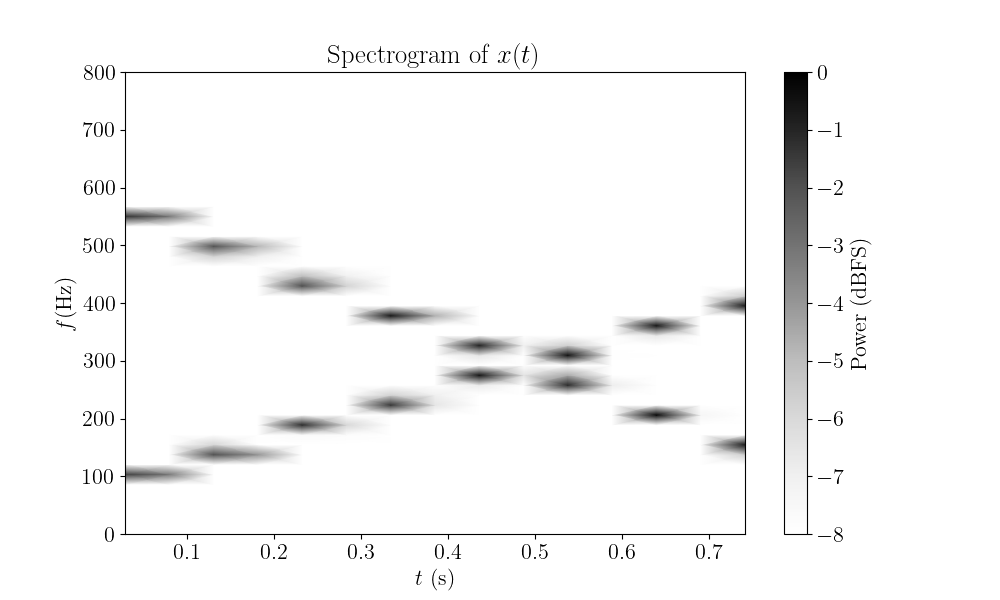

In [9]:
from scipy.fft import fftshift


def normalize(x):
    xmin = np.min(x)
    xmax = np.max(x)
    xnorm = (x - xmin) / (xmax - xmin)
    return xnorm


def normalize_eps_to_one(x, eps=1e-11):
    xnorm = normalize(x)
    x_scaled = xnorm * (1 - eps) + eps
    return x_scaled


def convert_power_to_dbfs(power_bins, eps=1e-11):
    power_bins_normalized = normalize_eps_to_one(power_bins, eps)
    power_bins_dbfs = 10 * np.log10(power_bins_normalized)
    return power_bins_dbfs


dynamic_range_db = 8

f_hz, t_sec, sxx_psd = signal.spectrogram(
    combined_signal_v, sampling_rate_hz, return_onesided=True, mode="psd"
)

sxx_dbfs = convert_power_to_dbfs(sxx_psd)

fh = plt.figure(figsize=(10, 6))
plt.pcolormesh(
    t_sec,
    fftshift(f_hz),
    fftshift(sxx_dbfs, axes=0),
    cmap="Greys",
    shading="gouraud",
    vmin=-dynamic_range_db,
    vmax=0,
)
plt.colorbar(label=r"Power (dBFS)")
plt.title(r"Spectrogram of $x(t)$")
plt.ylabel(r"$f \mathrm{(Hz)}$")
plt.xlabel(r"$t\ \mathrm{(s)}$")
plt.ylim([0, 800])